In [98]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [99]:
INIT_LR=1e-4
EPOCHS= 20
BS=32

In [100]:
'''import sys
sys.argv=['']
del sys
ap=argparse.ArgumentParser()
ap.add_argument("-d","--data",required=True,help="path to input dataset")

ap.add_argument("-p","--plot",type=str,default="plot.png",help="path to oututloss or accuracy plot")
ap.add_argument("-m","--model",type=str,default="cnnAction.h5",help="path to model") 
args=vars(ap.parse_args())
#args = ap.parse_args(args=[])'''

'import sys\nsys.argv=[\'\']\ndel sys\nap=argparse.ArgumentParser()\nap.add_argument("-d","--data",required=True,help="path to input dataset")\n\nap.add_argument("-p","--plot",type=str,default="plot.png",help="path to oututloss or accuracy plot")\nap.add_argument("-m","--model",type=str,default="cnnAction.h5",help="path to model") \nargs=vars(ap.parse_args())\n#args = ap.parse_args(args=[])'

In [104]:
print("info loading images...")
imagePaths=list(paths.list_images("data"))
data=[]
labels=[]

info loading images...


In [105]:
for imagepath in imagePaths:
    label=imagepath.split(os.path.sep)[-2] #here folder name is captured for each iamge it is closed or open
    #load input image and preprocess it 
    image=load_img(imagepath,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    #now data and label list will be updated like data is x label is y which image is open which is closed
    data.append(image)
    labels.append(label)
#convert data and label to array
data=np.array(data,dtype='float32')
labels=np.array(labels)
#perform one hot encoding to label
#lb=LabelBinarizer()
#lebels=lb.fit_transform(labels)
lb=LabelEncoder()
labels=lb.fit_transform(labels)
labels=to_categorical(labels,num_classes=2)
#split train test data
x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=42)

    
    

In [107]:
aug=ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest"
    
)

In [125]:
baseModel=MobileNetV2(weights="imagenet",include_top=False,
               input_tensor=Input(shape=(224,224,3)) )

In [126]:
headmodel=baseModel.output
headmodel=AveragePooling2D(pool_size=(7,7))(headmodel)
headmodel=Flatten(name='Flatten')(headmodel)
headmodel=Dense(128,activation='relu')(headmodel)
headmodel=Dropout(0.5)(headmodel)
headmodel=Dense(2,activation='softmax')(headmodel)

In [127]:
model=Model(inputs=baseModel.input,outputs=headmodel)

In [128]:
for layer in baseModel.layers:
    layer.trainable=False

In [129]:
import tensorflow as tf
learning_rate = 0.001
momentum = 0.9
nesterov = True
opt=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [130]:
h=model.fit(
aug.flow(x_train,y_train,batch_size=BS),
steps_per_epoch=len(x_train)//BS,
validation_data=(x_test,y_test),
validation_steps=len(x_test)//BS,
epochs=EPOCHS)

Epoch 1/20
36/36 [==============================] - 35s 876ms/step - loss: 0.6005 - accuracy: 0.7325 - val_loss: 0.3004 - val_accuracy: 0.9519
Epoch 2/20
36/36 [==============================] - 30s 846ms/step - loss: 0.2921 - accuracy: 0.9256 - val_loss: 0.1773 - val_accuracy: 0.9725
Epoch 3/20
36/36 [==============================] - 31s 858ms/step - loss: 0.1952 - accuracy: 0.9557 - val_loss: 0.1355 - val_accuracy: 0.9725
Epoch 4/20
36/36 [==============================] - 31s 869ms/step - loss: 0.1540 - accuracy: 0.9672 - val_loss: 0.1136 - val_accuracy: 0.9759
Epoch 5/20
36/36 [==============================] - 31s 860ms/step - loss: 0.1306 - accuracy: 0.9655 - val_loss: 0.1032 - val_accuracy: 0.9725
Epoch 6/20
36/36 [==============================] - 31s 859ms/step - loss: 0.1083 - accuracy: 0.9734 - val_loss: 0.0969 - val_accuracy: 0.9691
Epoch 7/20
36/36 [==============================] - 34s 937ms/step - loss: 0.1023 - accuracy: 0.9725 - val_loss: 0.0920 - val_accuracy: 0.9691

In [131]:
 #evaluation
pred=model.predict(x_test,batch_size=BS)
pred=np.argmax(pred,axis=1)

10/10 [==============================] - 5s 417ms/step


In [136]:
print(classification_report (y_test.argmax(axis=1),pred,target_names=lb.classes_))

              precision    recall  f1-score   support

       Close       0.97      0.97      0.97       145
        Open       0.97      0.97      0.97       146

    accuracy                           0.97       291
   macro avg       0.97      0.97      0.97       291
weighted avg       0.97      0.97      0.97       291



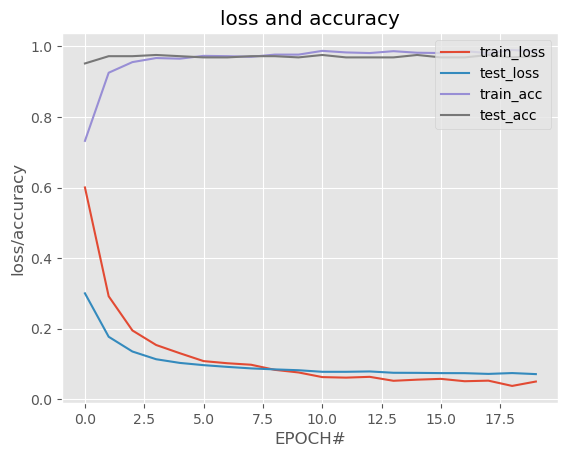

In [143]:
N=EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N),h.history['loss'],label='train_loss')
plt.plot(np.arange(0,N),h.history['val_loss'],label='test_loss')
plt.plot(np.arange(0,N),h.history['accuracy'],label='train_acc')
plt.plot(np.arange(0,N),h.history['val_accuracy'],label='test_acc')
plt.title("loss and accuracy")
plt.xlabel('EPOCH#')
plt.ylabel('loss/accuracy')
plt.legend(loc='upper right')
#plt.savefig(args['plot'])


In [144]:
model.save('models/cnnAction.h5', overwrite=True)

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
